# **Exploratory Data Analysis (EDA): EPA Fuel Economy Dataset (1984–2017)**
### What do we have?

## **1. Setup and Data Loading**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_selection import mutual_info_regression

In [2]:
df = pd.read_csv("database.csv", low_memory=False)

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (38113, 81)


,Vehicle ID,Year,Make,Model,Class,Drive,Transmission,Transmission Descriptor,Engine Index,Engine Descriptor,...,Hours to Charge (AC 240V),Composite City MPG,Composite Highway MPG,Composite Combined MPG,Range (FT1),City Range (FT1),Highway Range (FT1),Range (FT2),City Range (FT2),Highway Range (FT2)
0,26587,1984,Alfa Romeo,GT V6 2.5,Minicompact Cars,NaN,Manual 5-Speed,NaN,9001,(FFS),...,0.0,0,0,0,0,0.0,0.0,NaN,0.0,0.0
1,27705,1984,Alfa Romeo,GT V6 2.5,Minicompact Cars,NaN,Manual 5-Speed,NaN,9005,(FFS) CA model,...,0.0,0,0,0,0,0.0,0.0,NaN,0.0,0.0
2,26561,1984,Alfa Romeo,Spider Veloce 2000,Two Seaters,NaN,Manual 5-Speed,NaN,9002,(FFS),...,0.0,0,0,0,0,0.0,0.0,NaN,0.0,0.0
3,27681,1984,Alfa Romeo,Spider Veloce 2000,Two Seaters,NaN,Manual 5-Speed,NaN,9006,(FFS) CA model,...,0.0,0,0,0,0,0.0,0.0,NaN,0.0,0.0
4,27550,1984,AM General,DJ Po Vehicle 2WD,Special Purpose Vehicle 2WD,2-Wheel Drive,Automatic 3-Speed,NaN,1830,(FFS),...,0.0,0,0,0,0,0.0,0.0,NaN,0.0,0.0


## **1.2. Dataset Structure and Quality Check**

In [3]:
df.info()

missing_pct = (df.isnull().sum().sort_values(ascending=False) / len(df) * 100).round(2)
missing_pct.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38113 entries, 0 to 38112
Data columns (total 81 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Vehicle ID                           38113 non-null  int64  
 1   Year                                 38113 non-null  int64  
 2   Make                                 38113 non-null  object 
 3   Model                                38113 non-null  object 
 4   Class                                38113 non-null  object 
 5   Drive                                36924 non-null  object 
 6   Transmission                         38102 non-null  object 
 7   Transmission Descriptor              15045 non-null  object 
 8   Engine Index                         38113 non-null  int64  
 9   Engine Descriptor                    22693 non-null  object 
 10  Engine Cylinders                     37977 non-null  float64
 11  Engine Displacement         

Alternate Charger              99.88
Vehicle Charger                99.87
Electric Motor                 98.42
Supercharger                   98.18
Range (FT2)                    96.24
Fuel Type 2                    96.23
Gas Guzzler Tax                93.98
Alternative Fuel/Technology    92.01
Turbocharger                   86.25
Start Stop Technology          83.10
Manufacturer Code              80.80
Transmission Descriptor        60.53
Engine Descriptor              40.46
Drive                           3.12
Engine Cylinders                0.36
Engine Displacement             0.35
Transmission                    0.03
GHG Score (Alt Fuel)            0.00
2D Luggage Volume               0.00
2D Passenger Volume             0.00
dtype: float64

In [4]:
# Check for duplicate rows
num_duplicates = df.duplicated().sum()
print("Number of duplicate rows:", num_duplicates)

if num_duplicates > 0:
    display(df[df.duplicated()].head())

df = df.drop_duplicates()
print("Shape after dropping duplicates:", df.shape)


Number of duplicate rows: 0
Shape after dropping duplicates: (38113, 81)


## **1.3 . Data Dictionary (Selected Variables Used in Analysis)**

## Data Dictionary

- **Year** — Model year of the vehicle  
- **Make** — Manufacturer name (Honda, Ford, etc.)  
- **Model** — Vehicle model name  
- **Class** — EPA vehicle class (Small SUV, Midsize Car, etc.)  
- **Engine Cylinders** — Number of cylinders  
- **Engine Displacement** — Engine size (liters)  
- **Transmission** — Automatic or manual  
- **Fuel Type** — Gas, Hybrid, or Electric  
- **Drive** — 2-Wheel or 4-Wheel  
- **Combined MPG (FT1)** — **Target variable** (combined MPG)  
- **City MPG (FT1)** — City fuel economy  
- **Highway MPG (FT1)** — Highway fuel economy  
- **Annual Fuel Cost (FT1)** — Estimated yearly cost  
- **Tailpipe CO₂ (FT1)** — Emissions in grams per mile  
- **Range (FT1)** — Driving range on full tank/charge  


## **1.4 .Data Cleaning and Standardization**

In [5]:
# Simplify Fuel Type Categories
df = df.copy()

fuel_gas = {
    "Regular", "Premium", "Midgrade", "Diesel", "CNG",
    "Gasoline or natural gas", "Gasoline or E85", "Gasoline or propane",
    "Premium or E85"
}

fuel_hybrid = {
    "Premium Gas or Electricity", "Regular Gas and Electricity",
    "Premium and Electricity", "Regular Gas or Electricity"
}

df.loc[df["Fuel Type"].isin(fuel_gas), "Fuel Type"] = "Gas"
df.loc[df["Fuel Type"].isin(fuel_hybrid), "Fuel Type"] = "Hybrid"
df.loc[df["Fuel Type"] == "Electricity", "Fuel Type"] = "Electric"

print("Before filtering EVs:", df["Fuel Type"].value_counts())

# --- Remove Electric Vehicles ---
df = df[df["Fuel Type"].isin(["Gas", "Hybrid"])].copy()

print("\nAfter filtering EVs:", df["Fuel Type"].value_counts())
print("Dataset shape after EV removal:", df.shape)

df["Fuel Type"].unique()

Before filtering EVs: Fuel Type
Gas         37915
Electric      133
Hybrid         65
Name: count, dtype: int64

After filtering EVs: Fuel Type
Gas       37915
Hybrid       65
Name: count, dtype: int64
Dataset shape after EV removal: (37980, 81)


array(['Gas', 'Hybrid'], dtype=object)

In [6]:
#Simplify Drive Types
drive_4 = {
    "4-Wheel or All-Wheel Drive", "4-Wheel Drive",
    "All-Wheel Drive", "Part-time 4-Wheel Drive"
}
drive_2 = {"2-Wheel Drive", "Front-Wheel Drive", "Rear-Wheel Drive"}

df.loc[df["Drive"].isin(drive_4), "Drive"] = "4-Wheel"
df.loc[df["Drive"].isin(drive_2), "Drive"] = "2-Wheel"

df["Drive"] = df["Drive"].fillna(df["Drive"].mode()[0])
df["Drive"].unique()

array(['2-Wheel', '4-Wheel'], dtype=object)

In [7]:
cols_to_drop = [
    "Alternate Charger", "Vehicle Charger", "Electric Motor",
    "Supercharger", "Range (FT2)", "Fuel Type 2", "Gas Guzzler Tax",
    "Alternative Fuel/Technology", "Turbocharger", "Start Stop Technology",
    "Manufacturer Code", "Transmission Descriptor", "Engine Descriptor",
    "My MPG Data", "Fuel Type 1","Gasoline/Electricity Blended (CD)", "Tailpipe CO2 (FT1)",
    "Engine Index", "Vehicle ID"
    
]


df = df.drop(columns=cols_to_drop, errors="ignore")
df.shape

(37980, 62)

In [8]:
#fill NaNs w/ most common value per column
for col in df.columns:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].mode()[0])

#verify nothing important missing
df.isnull().sum().head(20)

Year                              0
Make                              0
Model                             0
Class                             0
Drive                             0
Transmission                      0
Engine Cylinders                  0
Engine Displacement               0
Fuel Type                         0
City MPG (FT1)                    0
Unrounded City MPG (FT1)          0
City MPG (FT2)                    0
Unrounded City MPG (FT2)          0
City Gasoline Consumption (CD)    0
City Electricity Consumption      0
City Utility Factor               0
Highway MPG (FT1)                 0
Unrounded Highway MPG (FT1)       0
Highway MPG (FT2)                 0
Unrounded Highway MPG (FT2)       0
dtype: int64

## **1.5 .Target Variable: Combined MPG (FT1)**

In [9]:
# Define target and features
target = "Combined MPG (FT1)"

y = df[target].copy()
X = df.drop(columns=[target])

print("X shape (features):", X.shape)
print("y shape (target):", y.shape)

X shape (features): (37980, 61)
y shape (target): (37980,)


## **1.6 .Univariate Analysis**

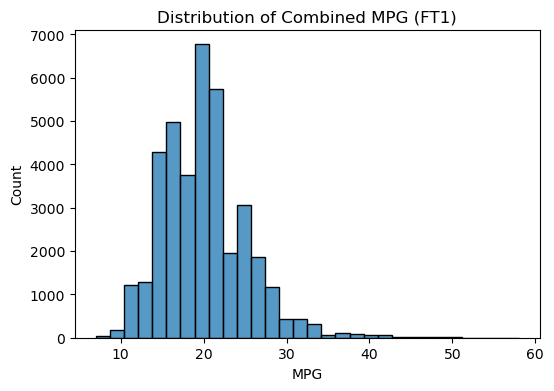

In [10]:
plt.figure(figsize=(6,4))
sns.histplot(df['Combined MPG (FT1)'], bins=30)
plt.title('Distribution of Combined MPG (FT1)')
plt.xlabel('MPG')
plt.ylabel('Count')
plt.show()

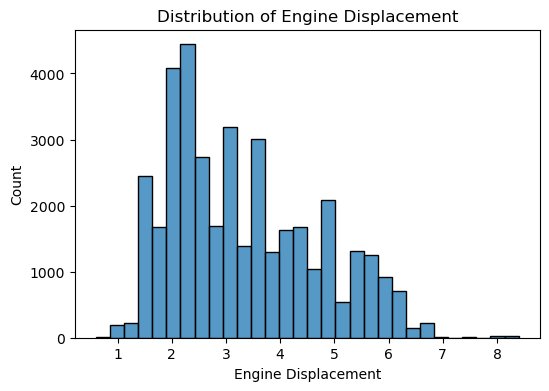

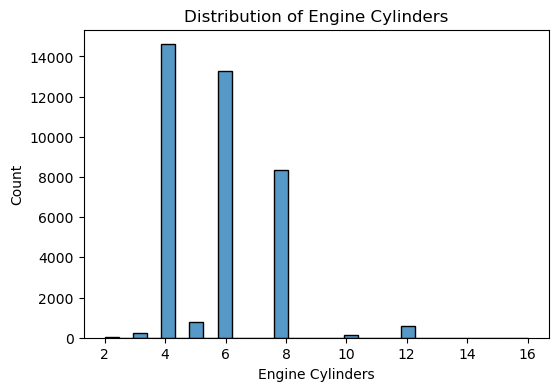

In [11]:
numeric_cols = ["Engine Displacement", "Engine Cylinders"]

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

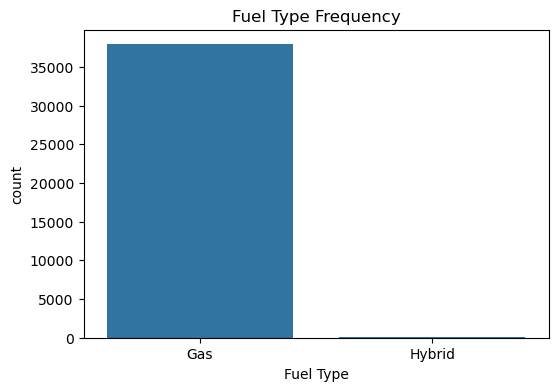

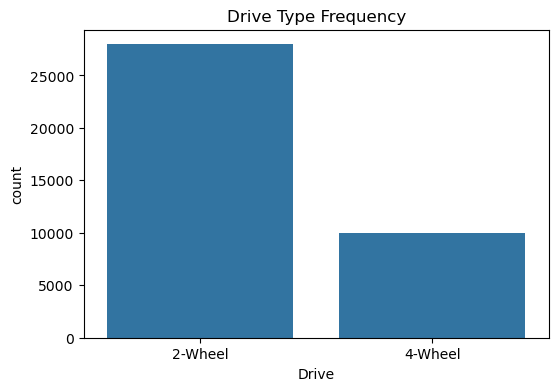

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Fuel Type')
plt.title('Fuel Type Frequency')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Drive')
plt.title('Drive Type Frequency')
plt.show()

## **1.7 .Bivariate Analysis**

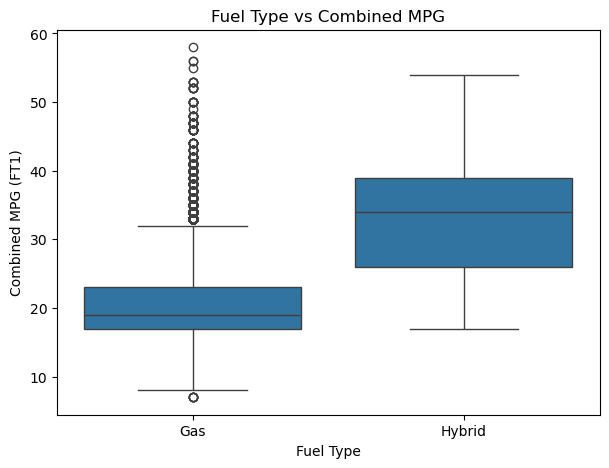

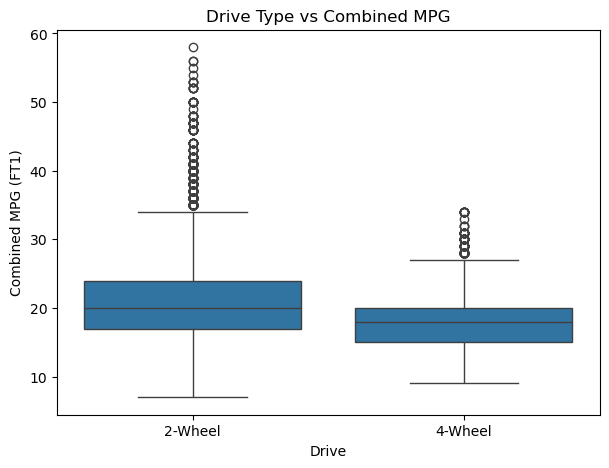

In [13]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x='Fuel Type', y=target)
plt.title('Fuel Type vs Combined MPG')
plt.show()

plt.figure(figsize=(7,5))
sns.boxplot(data=df, x='Drive', y=target)
plt.title('Drive Type vs Combined MPG')
plt.show()

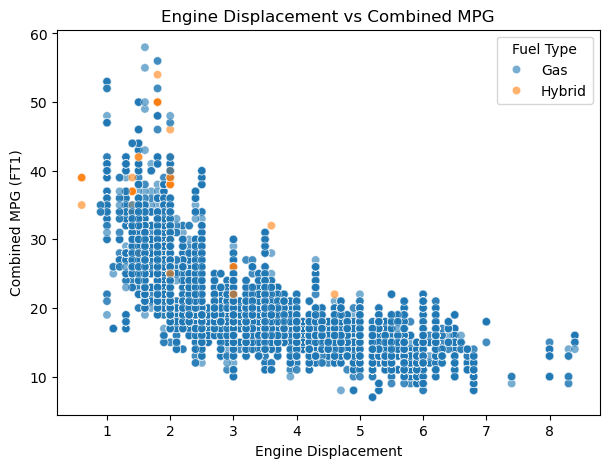

In [14]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='Engine Displacement', y=target, hue='Fuel Type', alpha=0.6)
plt.title('Engine Displacement vs Combined MPG')
plt.show()

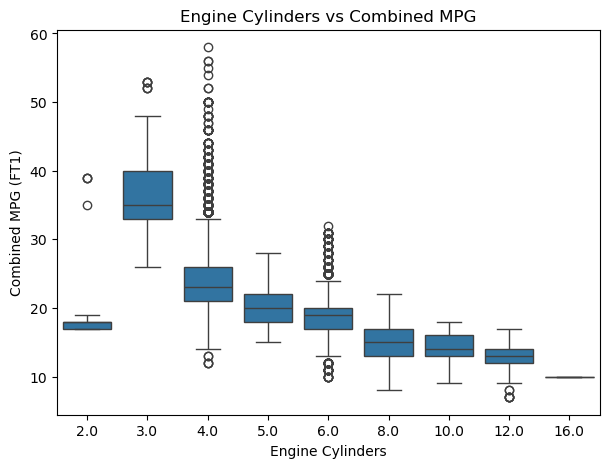

In [15]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x='Engine Cylinders', y='Combined MPG (FT1)')
plt.title('Engine Cylinders vs Combined MPG')
plt.show()

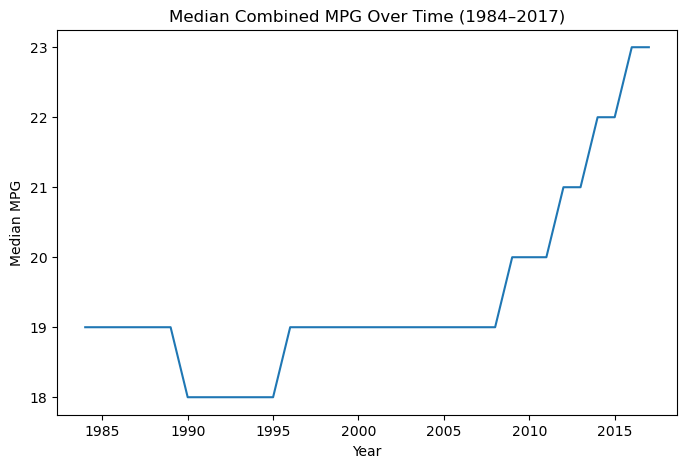

In [16]:
plt.figure(figsize=(8,5))
yearly = df.groupby('Year')[target].median()
sns.lineplot(x=yearly.index, y=yearly.values)
plt.title('Median Combined MPG Over Time (1984–2017)')
plt.xlabel('Year')
plt.ylabel('Median MPG')
plt.show()

## **1.8 .Correlation and Relationships**

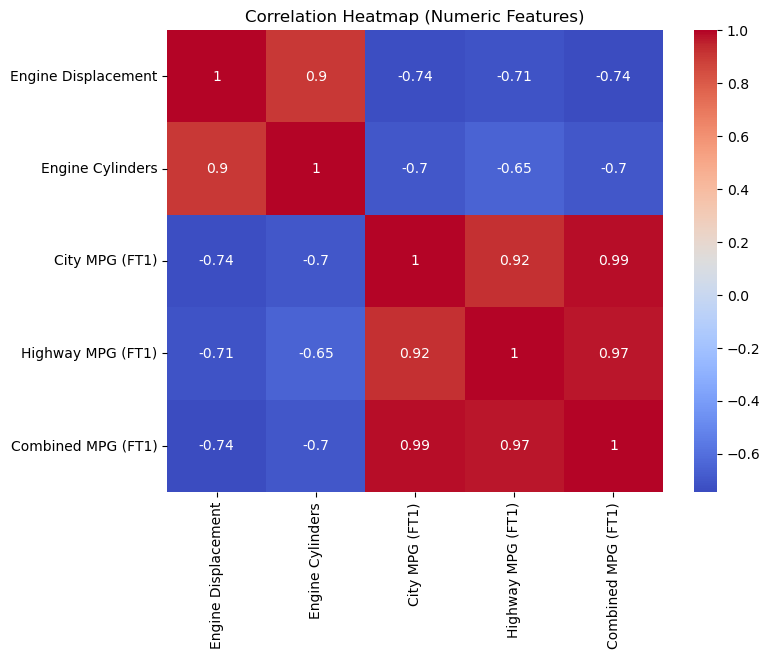

In [17]:
num_cols_view = [
    "Engine Displacement", "Engine Cylinders",
    "City MPG (FT1)", "Highway MPG (FT1)",
    target
]

plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols_view].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

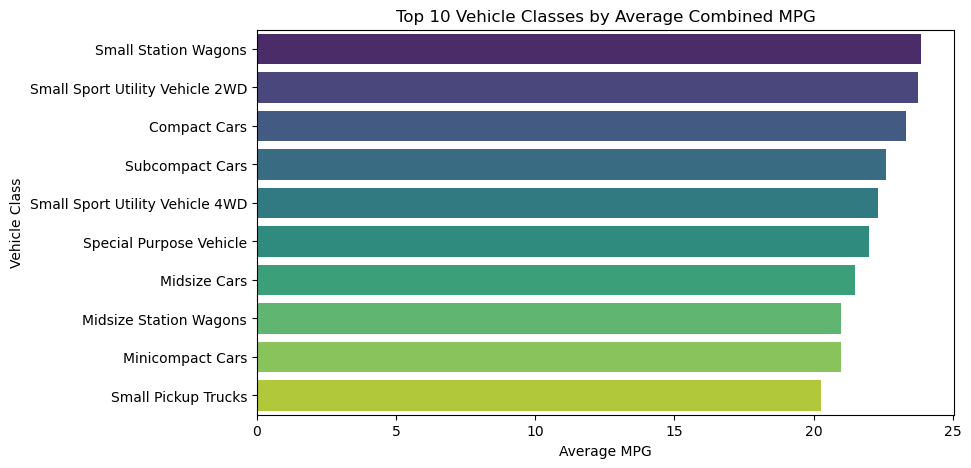

In [18]:
plt.figure(figsize=(9,5))
top_classes = df.groupby('Class')[target].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_classes.values, y=top_classes.index, palette='viridis')
plt.title('Top 10 Vehicle Classes by Average Combined MPG')
plt.xlabel('Average MPG')
plt.ylabel('Vehicle Class')
plt.show()

In [19]:
# Mean and median MPG by key categories
group_summary = pd.DataFrame({
    "Mean MPG": df.groupby("Fuel Type")[target].mean(),
    "Median MPG": df.groupby("Fuel Type")[target].median()
})

group_summary_drive = pd.DataFrame({
    "Mean MPG": df.groupby("Drive")[target].mean(),
    "Median MPG": df.groupby("Drive")[target].median()
})

print("=== MPG by Fuel Type ===")
display(group_summary)

print("=== MPG by Drive Type ===")
display(group_summary_drive)

=== MPG by Fuel Type ===


,Mean MPG,Median MPG
Fuel Type,,
Gas,19.939918,19.0
Hybrid,33.200000,34.0


=== MPG by Drive Type ===


,Mean MPG,Median MPG
Drive,,
2-Wheel,20.711195,20.0
4-Wheel,17.873752,18.0


### **1.9 Leakage Check**


There are multiple  variables in the dataset that directly encode MPG values or are derived mathematically from the MPG calculations,Using them in the modeling would cause **data leakage** meaning the model would cheat by learning information would not be available in real prediction scenarios.

These features below would be identified as possible leaking variables and will be excluded from the modeling :


- City MPG (FT1)  
- Highway MPG (FT1)  
- Unrounded Combined MPG (FT1)  
- Combined MPG (FT2)  
- Composite City MPG  
- Composite Highway MPG  
- Range (FT1)  
- Unrounded City/Highway MPG (FT2)
- Any other variable that contains MPG explicitly or implicitly

These features above are directly computed from the fuel consumption formulas which means they leak the target information, We only want variables that occur before the outcome (MPG) is determined.




## **Key Findings From the EDA**

Below are the most important patterns and insights discovered during exploratory analysis:

- **Fuel Type is a major determinant of MPG:**  
  The electric cars show the highest fuel efficiency, the hybrid cars fall in the middle and gasoline-powered vehicles consistently perform the worst, This confirms that fuel type is a strong predictive feature 


- **Engine size has a clear negative relationship with MPG:**  
  As the engine displacement and the cylinders increase the average combined MPG(FT1) decreases, Larger engines are less fuel efficient.

- **Drive train affects efficiency:**  
  Vehicles with **2-Wheel Drive** generally achieve higher MPG than **4-Wheel or All-Wheel Drive**.

- **Fuel efficiency has improved over time:**  
  As time goes on and we make technological progress the median MPG has steadily increased from 1984 to 2017.

- **Vehicle class affects fuel effeciency :**  
  Smaller vehicles like compact cars or small sport utility vehicles seem to have better MPG compared to the midsize station wagons and pick–up trucks due to weight and aerodynamics.

- **Strong correlations among MPG-related metrics indicate leakage risk:**  
  Variables like city MPG and Highway MPG are either highly correlated or derived from the target,They should be dropped to avoid leakage.

These findings directly inform our feature engineering, variable selection, and modeling strategy in later sections of the project.


Variables like city MPG and Highway MPG are either highly correlated or derived from the target,They should be dropped to avoid leakage.


## **2. What should we keep?**


## **2.1 Feature Reduction (Selecting ≤ 20 Best Features)**

In [20]:
target = "Combined MPG (FT1)"

X = df.drop(columns=[target]).copy()
y = df[target].copy()

initial_feature_count = X.shape[1]
initial_feature_count

61

In [21]:
#Remove near-constant features
low_var = [c for c in X.columns if X[c].nunique() <= 1]

X_reduced = X.drop(columns=low_var)
print("Dropped low-variance:", low_var)
print("Remaining:", X_reduced.shape[1])

Dropped low-variance: ['Hours to Charge (120V)', 'Hours to Charge (AC 240V)', 'Range (FT1)', 'City Range (FT1)', 'Highway Range (FT1)']
Remaining: 56


In [22]:
#Remove highly correlated numeric features (≥ 0.85)
num_cols = X_reduced.select_dtypes(include=[np.number]).columns
corr_matrix = X_reduced[num_cols].corr().abs()

to_drop_corr = set()

for col in corr_matrix.columns:
    highly_corr = corr_matrix.index[(corr_matrix[col] >= 0.85) & (corr_matrix.index != col)]
    for h in highly_corr:
        # skip domain-critical features
        if h not in ["Engine Displacement", "Engine Cylinders"]:
            to_drop_corr.add(h)

X_reduced = X_reduced.drop(columns=list(to_drop_corr), errors='ignore')

print("Dropped high-correlation features:", to_drop_corr)
print("Remaining:", X_reduced.shape[1])


Dropped high-correlation features: {'Highway Gasoline Consumption (CD)', 'Annual Fuel Cost (FT2)', 'Annual Consumption in Barrels (FT1)', 'Highway MPG (FT2)', 'Composite Combined MPG', 'Unadjusted Highway MPG (FT1)', 'City Electricity Consumption', 'Hatchback Passenger Volume', '4D Luggage Volume', 'GHG Score', 'Combined Utility Factor', 'Fuel Economy Score', 'Unadjusted Highway MPG (FT2)', 'Annual Fuel Cost (FT1)', 'Combined MPG (FT2)', 'Unadjusted City MPG (FT2)', 'Tailpipe CO2 in Grams/Mile (FT1)', 'Highway Range (FT2)', 'Combined Gasoline Consumption (CD)', 'Highway Electricity Consumption', 'City Utility Factor', '2D Passenger Volume', '2D Luggage Volume', 'Unrounded Combined MPG (FT2)', 'Unrounded Highway MPG (FT1)', 'City MPG (FT2)', 'Tailpipe CO2 in Grams/Mile (FT2)', 'Unrounded City MPG (FT2)', 'Composite City MPG', 'Unrounded Combined MPG (FT1)', 'Annual Consumption in Barrels (FT2)', 'Unrounded City MPG (FT1)', 'Tailpipe CO2 (FT2)', 'Unrounded Highway MPG (FT2)', 'Unadjusted

In [23]:
num_cols = X_reduced.select_dtypes(include=[np.number]).columns
cat_cols = X_reduced.select_dtypes(exclude=[np.number]).columns

# numeric correlation with target
corr_with_target = X_reduced[num_cols].corrwith(y).abs().sort_values(ascending=False)

# mutual information for categorical
if len(cat_cols) > 0:
    dummies = pd.get_dummies(X_reduced[cat_cols], drop_first=True)
    mi_vals = mutual_info_regression(dummies, y, random_state=0)
    mi = pd.Series(mi_vals, index=dummies.columns).sort_values(ascending=False)

    # group MI back to original feature names
    mi_grouped = mi.groupby(lambda s: s.split("_")[0]).max()
else:
    mi_grouped = pd.Series(dtype=float)

corr_with_target, mi_grouped.head()

(Engine Displacement    0.744970
 Engine Cylinders       0.697545
 Year                   0.175921
 dtype: float64,
 Class        0.045723
 Drive        0.048137
 Fuel Type    0.002438
 Make         0.027061
 Model        0.012525
 dtype: float64)

In [24]:
#select top 20
top_numeric = list(corr_with_target.index[:10])
top_categorical = list(mi_grouped.index[:10])

selected = list(dict.fromkeys(top_numeric + top_categorical)) 

# force keep domain-critical
for col in ["Engine Displacement", "Engine Cylinders"]:
    if col not in selected:
        selected.append(col)

# enforce ≤ 20
selected = selected[:20]

final_feature_count = len(selected)

print("Selected features:", selected)
print("Final feature count:", final_feature_count)


Selected features: ['Engine Displacement', 'Engine Cylinders', 'Year', 'Class', 'Drive', 'Fuel Type', 'Make', 'Model', 'Transmission']
Final feature count: 9


In [25]:
records = []

num_scores = corr_with_target.to_dict()
cat_scores = mi_grouped.to_dict()

for col in X_reduced.columns:
    if col in selected:
        reason = []
        if col in num_scores:
            reason.append(f"corr={num_scores[col]:.2f}")
        if col in cat_scores:
            reason.append(f"MI={cat_scores[col]:.3f}")

        preprocess = "scale" if col in num_cols else "encode"

        records.append({
            "Feature": col,
            "Keep?": "YES",
            "Reason": ", ".join(reason),
            "Preprocess": preprocess
        })
    else:
        records.append({
            "Feature": col,
            "Keep?": "NO",
            "Reason": "Filtered out",
            "Preprocess": "-"
        })

feature_summary = pd.DataFrame(records).sort_values("Keep?", ascending=False)
feature_summary

,Feature,Keep?,Reason,Preprocess
0,Year,YES,corr=0.18,scale
1,Make,YES,MI=0.027,encode
2,Model,YES,MI=0.013,encode
3,Class,YES,MI=0.046,encode
4,Drive,YES,MI=0.048,encode
5,Transmission,YES,MI=0.043,encode
6,Engine Cylinders,YES,corr=0.70,scale
7,Engine Displacement,YES,corr=0.74,scale
8,Fuel Type,YES,MI=0.002,encode


In [26]:
print("Initial feature count:", initial_feature_count)
print("Final feature count:", final_feature_count)

Initial feature count: 61
Final feature count: 9


## **3. Preprocessing & Splits**

In [27]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [28]:
# Final selected features 
selected_features = [
    "Year",
    "Make",
    "Model",
    "Class",
    "Drive",
    "Transmission",
    "Engine Cylinders",
    "Engine Displacement",
    "Fuel Type"
]

# Define X and y
X = df[selected_features].copy()
y = df["Combined MPG (FT1)"].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (37980, 9)
y shape: (37980,)


## **3.1 Identify Feature Types**


In [29]:
numeric_features = ["Year", "Engine Cylinders", "Engine Displacement"]
categorical_features = ["Make", "Model", "Class", "Drive", "Transmission", "Fuel Type"]

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

Numeric: ['Year', 'Engine Cylinders', 'Engine Displacement']
Categorical: ['Make', 'Model', 'Class', 'Drive', 'Transmission', 'Fuel Type']


## **3.2 Train/Test Split (80/20)**


In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=0
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (30384, 9)
Test size: (7596, 9)


## **3.3 Preprocessing Pipeline**


In [31]:
# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

print(preprocessor)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Year', 'Engine Cylinders',
                                  'Engine Displacement']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['Make', 'Model', 'Class', 'Drive',
                                  'Transmission', 'Fuel Type'])])


## **3.4 Cross-Validation**

In [32]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)

print(cv)

KFold(n_splits=5, random_state=0, shuffle=True)


In [33]:
# Combine selected features + target for export
df_modeling = pd.concat([X, y], axis=1)

df_modeling.to_csv("modeling_dataset.csv", index=False)

print("Saved: modeling_dataset.csv with shape:", df_modeling.shape)


Saved: modeling_dataset.csv with shape: (37980, 10)
